In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dogs-vs-cats', 'dogs-vs-cats-for-pytorch']


In [11]:
# from os import walk
# for (dirpath, dirnames, filenames) in walk("../input/dogs-vs-cats"):
#     print("Directory path: ", dirpath)
#     print("Folder name: ", dirnames)
#     print("File name: ", filenames)

In [12]:
# from os import walk
# for (dirpath, dirnames, filenames) in walk("../input/dogs-vs-cats-for-pytorch"):
#     print("Directory path: ", dirpath)
#     print("Folder name: ", dirnames)
#     print("File name: ", filenames)

Implementation

In [13]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
PATH=Path('../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data')
PATH1=Path('../input/dogs-vs-cats/test1')

In [16]:
TRAIN =Path(PATH/'train')
VALID = Path(PATH/'test')
PATH1 = VALID
TEST=Path(PATH1)
print(TRAIN)
print(VALID)
print(TEST)

../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/train
../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/test
../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/test


No of dog images for training

In [17]:
ls ../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/train/dog -1 | wc -l

11250


No of Cat images for training

In [18]:
ls ../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/train/cat -1 | wc -l

11250


No of Dog images for validation

In [19]:
ls ../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/test/dog -1 | wc -l

1250


No of Cat images for validation

In [20]:
ls ../input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/test/cat -1 | wc -l

1250


No of images to predict

In [21]:
ls ../input/dogs-vs-cats/test1/test1 -1 | wc -l

ls: cannot access '../input/dogs-vs-cats/test1/test1': No such file or directory
0


In [22]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# choose the training and test datasets

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data=datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(PATH1, transform=test_transforms)

# obtain training indices that will be used for validation
#num_train = len(train_data)
#indices = list(range(num_train))
#np.random.shuffle(indices)
#split = int(np.floor(valid_size * num_train))
#print("Split Index",split)
#train_idx, valid_idx = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches


In [23]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


In [24]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [25]:
images,labels=next(iter(train_loader))

In [26]:
images.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['cat','dog']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

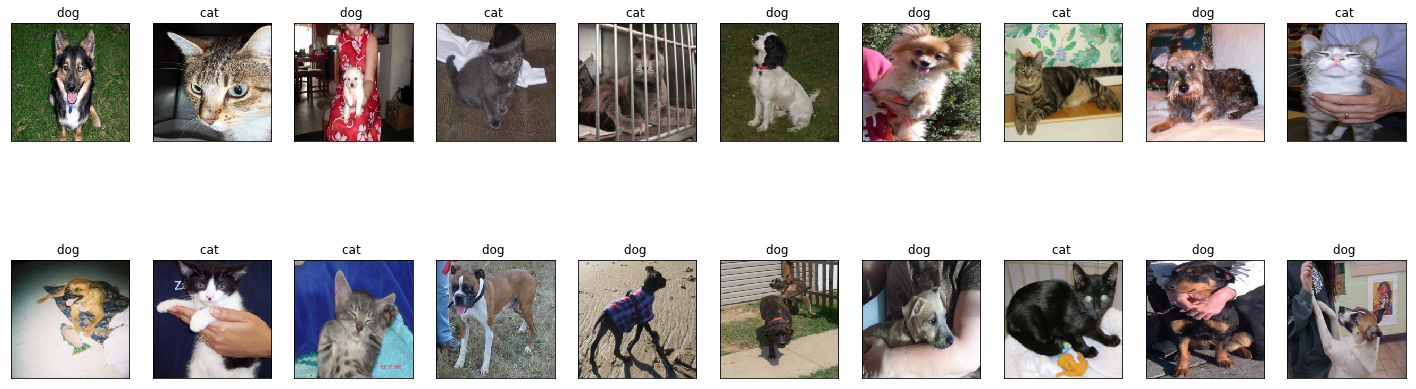

In [28]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

![](http://)Load the model VGG -19

In [29]:
vgg_19=models.vgg19_bn(pretrained=True)
vgg_19

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
 10%|▉         | 56328192/574769405 [00:04<00:44, 11750098.45it/s]


KeyboardInterrupt: 

In [ ]:
# Freeze parameters so we don't backprop through them
for param in vgg_19.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1028)),
                          ('relu1', nn.ReLU()),
                          ('dropout1',nn.Dropout(0.5)),
                          ('fc2', nn.Linear(1028, 512)),
                          ('relu2', nn.ReLU()), 
                          ('dropout2',nn.Dropout(0.5)),
                          ('fc3', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
vgg_19.classifier = classifier

In [ ]:
vgg_19

In [ ]:
criterion = nn.NLLLoss()
optimizer=torch.optim.Adam(vgg_19.parameters(),lr=0.01)

In [ ]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [ ]:
if train_on_gpu:
    vgg_19.cuda()
# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg_19.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg_19.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg_19.state_dict(), 'model_vgg19.pth')
        valid_loss_min = valid_loss

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
batch_size=4
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg_19.eval()
# iterate over valid data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg_19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
batch_size=32
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
vgg_19.cpu()
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
#if train_on_gpu:
    #images = images.cuda()

# get sample outputs
output = vgg_19(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
print("The state dict keys: \n\n", vgg_19.state_dict().keys())

In [ ]:
torch.save(vgg_19.state_dict(), 'checkpoint_97.pth')

vgg_19.load_state_dict(state_dict)

In [ ]:
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(vgg_19.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 3 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Number of epochs

In [ ]:
if train_on_gpu:
    vgg_19.cuda()
# number of epochs to train the model
n_epochs = 2

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg_19.train()
    
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        scheduler.step()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg_19.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg_19(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg_19.state_dict(), 'model_vgg19_2.pth')
        valid_loss_min = valid_loss

In [ ]:
batch_size=4
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg_19.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg_19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

References
<br>
[Notebook](https://www.kaggle.com/pocahontas1010/cats-dogs-classifier-with-pytorch/notebook)
<br>
[Sorting data into subdirectories](https://www.kaggle.com/c/dog-breed-identification/discussion/48908)
<br>
[Model evaluation](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)
<br>
[Pytorch Models](https://pytorch.org/docs/stable/torchvision/models.html[Pytorch Models])
<br>
[Pytorch Augmetation](https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll)